In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from yellowbrick.classifier import ClassificationReport

/home/julien/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
%matplotlib inline
pd.set_option('display.max_columns', 55)

In [3]:
#read in csv
df = pd.read_csv("bigtable.csv")

In [4]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]#.astype(np.float64)

df = pd.read_csv("bigtable.csv")
df = clean_dataset(df).reset_index()

features = df[[
    'population', 
    'dist-mroads', 
    'dist-setl', 
    'dist-coast', 
    'dist-forest', 
    'slope', 
    'elevation', 
    'dayofweek', 
    'sin_day', 
    'cos_day',
    'sin_year', 
    'cos_year', 
    'TEMP', 
    'Wind-Dir', 
    'Wind-Rate', 
    'DEW', 
    'SKY', 
    'VIS', 
    'ATM'
]].astype(np.float64)

features.loc[:,'dayofweek'] = features['dayofweek'].astype('category')

gs = df[['station_id']]

labels = df[[
    'pm25',
    'AQI_VALUE', #pm25 transformed using EPA methodology
    'AQI_class'  #pm25 transformed into EPA categorical class
]]

labels.loc[:,"polluted"] = (labels["AQI_class"] != "Good")

y=labels["polluted"]
X=features

/home/julien/.local/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/julien/.local/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
dict(features.dtypes)

{'population': dtype('float64'),
 'dist-mroads': dtype('float64'),
 'dist-setl': dtype('float64'),
 'dist-coast': dtype('float64'),
 'dist-forest': dtype('float64'),
 'slope': dtype('float64'),
 'elevation': dtype('float64'),
 'dayofweek': CategoricalDtype(categories=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], ordered=False),
 'sin_day': dtype('float64'),
 'cos_day': dtype('float64'),
 'sin_year': dtype('float64'),
 'cos_year': dtype('float64'),
 'TEMP': dtype('float64'),
 'Wind-Dir': dtype('float64'),
 'Wind-Rate': dtype('float64'),
 'DEW': dtype('float64'),
 'SKY': dtype('float64'),
 'VIS': dtype('float64'),
 'ATM': dtype('float64')}

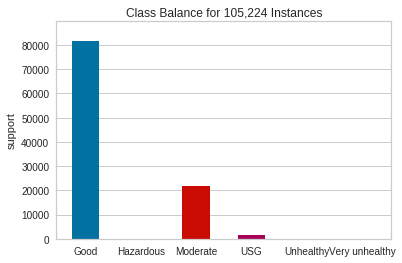

In [6]:
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(
    #labels=["Good", "USG", "Moderate", "Unhealthy", "Very unhealthy", "Hazardous"], size=(1080, 720)
)

visualizer.fit(df['AQI_class'].values)
visualizer.show()

In [7]:
df['AQI_class'].value_counts


<bound method IndexOpsMixin.value_counts of 0          USG
1          USG
2         Good
3         Good
4         Good
          ... 
105219    Good
105220    Good
105221    Good
105222    Good
105223    Good
Name: AQI_class, Length: 105224, dtype: object>

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns


numeric_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
 http://localhost:8888/tree?token=7020ad73c3380d9445ef190c397df88fc79ce2baad2f34d5   transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])



In [9]:
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)

    model = Pipeline([
     ('preprocessor', preprocessor),
     ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [10]:
# Try them all! Looking for Pokemons

models = [
    SVC(gamma='auto'),
    # NuSVC(gamma='auto'), LinearSVC(), 
    #SGDClassifier(max_iter=100, tol=1e-3), 
    KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), #LogisticRegressionCV(cv=3), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]


for model in models:
    score_model(X, y, model)

SVC: 0.5212134474929562
KNeighborsClassifier: 0.7867330462863295
LogisticRegression: 0.30416468725257323
BaggingClassifier: 0.9529779223001882
ExtraTreesClassifier: 0.955900089910309
RandomForestClassifier: 0.9569425115084038


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

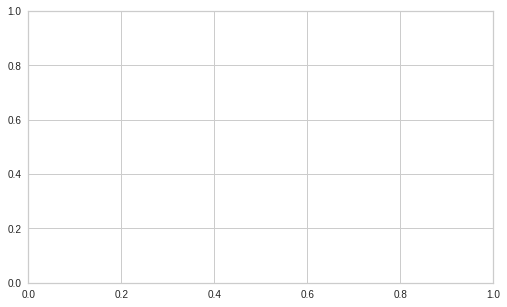

In [13]:
def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)

    model = Pipeline([
     ('preprocessor', preprocessor),
     ('estimator', estimator)
    ])
    
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, 
        classes=['Good', 'Not good'], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20)
    
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.show()  

#keeping best ones
models = [
    #SVC(gamma='auto'),
    # NuSVC(gamma='auto'), LinearSVC(), 
    #SGDClassifier(max_iter=100, tol=1e-3), 
    #KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), #LogisticRegressionCV(cv=3), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]

for model in models:
    visualize_model(X, y, model)

In [ ]:
X[np.isclose(X["cos_year"], -0.1099)]

# To avoid or detect overfitting to groundstations conditions (too few ground stations)

Let s shuffle Training and test data based on Groundstations id

Only 13 stations, so let's use 10 for training and 3 for testing.


2.6
Test substations selected: 
['Cheverly 9', '[{name=US EPA AirNow, url=http://www.airnow.gov/}, {name=District of Columbia - Department of Energy and Environment, url=null}]']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

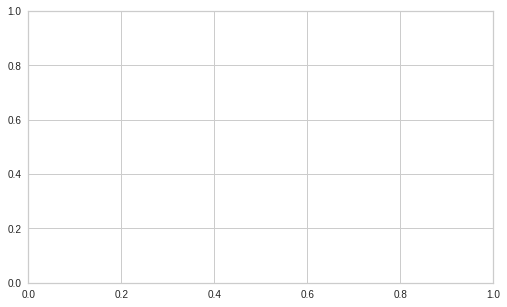

In [14]:
import random

def tts_gs(X, y, gs, test_size):
    stations = gs["station_id"].unique()
    nb_stations = len(stations) * test_size
    print(nb_stations)
    my_randoms = random.sample(list(stations), int(nb_stations))
    filters = gs["station_id"].isin(my_randoms)
    print('Test substations selected: ')
    print(my_randoms)
    return X[~filters], X[filters], y[~filters], y[filters]


def visualize_model_gs(X_train, X_test, y_train, y_test, estimator):
    """
    Test various estimators.
    """ 
    #y = LabelEncoder().fit_transform(y)
    y_train = LabelEncoder().fit_transform(y_train)
    y_test = LabelEncoder().fit_transform(y_test)
    
    model = Pipeline([
     ('preprocessor', preprocessor),
     ('estimator', estimator)
    ])


    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, 
        classes=['Good', 'Not good'], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    #X_train, X_test, y_train, y_test = tts_gs(X, y, gs, test_size=0.20)
    #import pdb; pdb.set_trace()
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.show()  

X_train, X_test, y_train, y_test = tts_gs(X, y, gs, test_size=0.20)
    
for model in models:
    visualize_model_gs(X_train, X_test, y_train, y_test, model)

In [ ]:
#Let's remove all x/y features and keep just "postion in decimal degrees"
features_noGIS = df[[
    'x',
    'y',
    'dayofweek', 
    'sin_day', 
    'cos_day',
    'sin_year', 
    'cos_year', 
    'TEMP', 
    'Wind-Dir', 
    'Wind-Rate', 
    'DEW', 
    'SKY', 
    'VIS', 
    'ATM'
]].astype(np.float64)

features_noGIS.loc[:,'dayofweek'] = features['dayofweek'].astype('category')

X=features_noGIS
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns


models = [
    #SVC(gamma='auto'),
    # NuSVC(gamma='auto'), LinearSVC(), 
    #SGDClassifier(max_iter=100, tol=1e-3), 
    #KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), #LogisticRegressionCV(cv=3), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]

In [ ]:
X_train, X_test, y_train, y_test = tts_gs(X, y, gs, test_size=0.20)
    
for model in models:
    visualize_model_gs(X_train, X_test, y_train, y_test, model)